In [2]:
from tensorflow.keras.models import Sequential
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Activation,Dropout,Conv2D,MaxPooling2D,Flatten,Embedding,LSTM,Conv1D,MaxPooling1D
from tensorflow.keras.layers import Reshape,RepeatVector,Permute,Lambda,ActivityRegularization,Masking,Conv1D,Conv3D
from tensorflow.keras.layers import GlobalAveragePooling1D,Input,SeparableConv1D,SeparableConv2D,concatenate
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
from tensorflow.keras.applications import VGG16
import os
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model

In [3]:
vgg_m = VGG16(include_top=False,input_shape=(240,240,3))    


# 设计网络结构

In [4]:
def create_model_v2():
    vgg_m = VGG16(include_top=False,input_shape=(240,240,3))    
    ipt_vd = Input((40,240,240,3))
    def extend_vd_img(x):
#         print(x.shape)
        tfs = []
        for i in range(x.shape[1]):
            img_tf = x[:,i,:,:]
            tfs.append( img_tf)
        return tfs

    lambda_out = layers.Lambda(extend_vd_img)(ipt_vd)
#     print(len(lambda_out))
    vgg_fs = []
    img_s = []
    for i in lambda_out:
#         print(i.shape)
        vgg_fs.append(vgg_m(i))
        img_s.append(i)
#     out = concatenate(vgg_fs)
    out = [img_s,vgg_fs]
#     out = Reshape((40,7,7,512))(out)
    m = Model(inputs=ipt_vd,outputs=out)
    print('v2 model',m.input_shape,m.output_shape)
    return m
# m1.summary()
# m2 = create_model_v2()


# 测试网络结构输出是否一直

In [5]:
m_v2 = create_model_v2()
# plot_model(m_v1,to_file='model_pic/vgg_test40_frame.png',show_shapes=True,show_dtype=True,)


v2 model (None, 40, 240, 240, 3) [[(None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3), (None, 240, 240, 3)], [(None, 7, 7, 512), (None, 7, 7, 512), (None, 7, 7, 512), (None, 7, 7, 512), (None, 7, 7, 512), (None, 7, 7, 512), (None, 7,

In [6]:
# plot_model(m_v2,to_file='model_pic/vgg_test40_frame-v2.png',show_shapes=True,show_dtype=True,)

In [7]:
n = 4
x_bath = np.random.randint(0,10,size=(n,40,240,240,3))
    
x_bath.astype(np.uint8).shape


(4, 40, 240, 240, 3)

## 检查模型预测稳定性，ok

In [8]:
[x_pred2_a,vgg_f_a] = m_v2.predict(x_bath)
[x_pred2_b,vgg_f_b] = m_v2.predict(x_bath)

In [9]:
for i in range(len(x_pred2_a)):
#     print(x_pred2_a[i].shape)
    t1 = x_pred2_a[i]
    t2 = x_pred2_b[i]    
    print(np.unique(t1==t2).flatten())

[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]


In [10]:
for i in range(len(vgg_f_a)):
#     print(x_pred2_a[i].shape)
    t1 = vgg_f_a[i]
    t2 = vgg_f_b[i]    
    print(np.unique(t1==t2).flatten())

[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]


## 检查模型集成vgg抽取特征和直接预测特征的差异

In [11]:
[x_pred2,vgg_f] = m_v2.predict(x_bath)


In [12]:
rs_vggs=[]
rs2s=[]
i_s=[]
j_s=[]
diff_rs=np.array([])
for i in range(40):
#     print(i,x_pred2[i].shape)
    for j in range(n):
        pred_img2 = x_pred2[i][j]
        vgg_pred_f = vgg_f[i][j]
        x_batch_img = x_bath[j][i]
        vgg_each_f = vgg_m.predict(x_batch_img.reshape(1,240,240,3))
        vgg_each_f = vgg_each_f.reshape(7,7,512)
        rs_vgg_f_diff = vgg_each_f==vgg_pred_f
        rs2 = pred_img2==x_batch_img   
        rs2 = np.unique(rs2.flatten())
#         print(diff_rs.shape)
        diff_rs = np.append(diff_rs,(vgg_each_f-vgg_pred_f).flatten(),)
        i_s.append(i)
        j_s.append(j)
        rs2s.append(str(rs2))    
        rs_vggs.append(pd.DataFrame(rs_vgg_f_diff.flatten())[0].value_counts())

In [13]:
len(diff_rs)

4014080

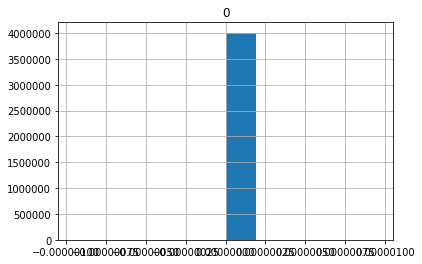

In [14]:
diff_df = pd.DataFrame(diff_rs)
diff_df.hist()
plt.show()


In [15]:
diff_df.describe()
# 此处有微小的预测值差异，原因在哪里？图片输入相同但是vgg预测不同。

,0
count,4.014080e+06
mean,2.551921e-12
std,6.650700e-09
min,-9.536743e-07
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,9.536743e-07


In [16]:
vgg_each_f.shape

(7, 7, 512)

In [17]:
vgg_pred_f.shape

(7, 7, 512)

In [18]:
rs_a = pd.DataFrame({'i':i_s,'j':j_s,'rs2':rs2s,'rs_vggs':rs_vggs})

In [19]:
rs_a.rs2.value_counts()

[ True]    160
Name: rs2, dtype: int64

In [20]:
# 
rs_a

,i,j,rs2,rs_vggs
0,0,0,[ True],"True 25025 False 63 Name: 0, dtype: ..."
1,0,1,[ True],"True 25025 False 63 Name: 0, dtype: ..."
2,0,2,[ True],"True 25042 False 46 Name: 0, dtype: ..."
3,0,3,[ True],"True 25035 False 53 Name: 0, dtype: ..."
4,1,0,[ True],"True 25023 False 65 Name: 0, dtype: ..."
...,...,...,...,...
155,38,3,[ True],"True 24999 False 89 Name: 0, dtype: ..."
156,39,0,[ True],"True 25026 False 62 Name: 0, dtype: ..."
157,39,1,[ True],"True 25016 False 72 Name: 0, dtype: ..."
158,39,2,[ True],"True 25026 False 62 Name: 0, dtype: ..."
